# Is it possible to predict which team will win based on the first 10min of the game?

## Abstract

This paper focuses on predicting game outcomes using different machine learning algorithms based on the first 10 min states from LOL game. This helps players get edge in the game, since, we can predict which features are important to win in the first 10 min of the game. The metrics chosen to assess the performance of the model is the accuracy, hence, the problem utilized several machine learning predictive models. One finding was that the accuracy of models ranges from 68-74%, in particular, Logistics Regression showed the best performance. Also, the train and test sets showed similar accuracy. PCA and LDA didn't help much since their results were not perfectly linearly separable. Furthermore, standardizing and normalizing dataset only affect models' accuracy slightly. Another finding was that we can be roughly 70% sure whether a blue team or red team is going to win based on first 10mins of gameplay stats by considering the result from Tensorflow Keras's classification and GridSearchCV.


The accuracy of models ranges from 68-74%. Logisitic Regression does better in classifying. Keras/Tensorflow with single layer using softmax activation worked better on raw, standard scaled and min max scaled data. So, using the models we can be ~70% sure whether a blue team or red team is going to win based on first 10mins of game play stats.

## Introduction

*The data includes first 10 min stats from League of Legends Game including the target value whether the blue team won or not. The goal is to analyse features to predict winning team and also get statistical output of which features are more important in winning the game in the first 10 min. This is important because it helps gamers to better strategize the game. Then, the process was to apply several machine learning techniques such as Decision Tree, Logistic Regression, and so on. Interestingly, Logistic Regression had the highest accuracy. We also conducted methods such as cross validation and GridSearchCV to find the best parameters for each model. Additionally, Roc Auc curve was used to improve our model accuracy and to look for model overfitting or underfitting.*

## Background

Similarly, a data scientist named Shayaan Jagtap(2018) wrote about predicting game outcomes by looking at key features such as kills, gold differences, etc. Jagtap conducted several predictive models, particularly, a Logistics Regression with a 75.78% accuracy, one of the best models of the highest accuracy, in the first 15 mins of the game, which is very close to our result. Interestingly, Jagtap found out that the chance of correctly predicting the winning team in the early game(about first 5 minutes) was not very high since ‘Your enemy could always turn the tide.' However, the prediction become more accurate as the game went on.

## Data

### EDA

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV,cross_val_score, learning_curve, validation_curve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import plot_confusion_matrix, f1_score, precision_score, accuracy_score, recall_score, confusion_matrix, classification_report, roc_curve, auc
%matplotlib inline

In [9]:
# Random Seed
SEED = 42
np.random.seed = SEED

In [10]:
dataurl = '../datasets/high_diamond_ranked_10min.csv'
df = pd.read_csv(dataurl)
df.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [11]:
print('Shape of Data, # of Rows {} and # of Columns {}'.format(df.shape[0], df.shape[1]))

Shape of Data, # of Rows 9879 and # of Columns 40


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

In [13]:
df.iloc[:, 2:20].columns

Index(['blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood', 'blueKills',
       'blueDeaths', 'blueAssists', 'blueEliteMonsters', 'blueDragons',
       'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin'],
      dtype='object')

In [14]:
df.iloc[:, 21:].columns

Index(['redWardsPlaced', 'redWardsDestroyed', 'redFirstBlood', 'redKills',
       'redDeaths', 'redAssists', 'redEliteMonsters', 'redDragons',
       'redHeralds', 'redTowersDestroyed', 'redTotalGold', 'redAvgLevel',
       'redTotalExperience', 'redTotalMinionsKilled',
       'redTotalJungleMinionsKilled', 'redGoldDiff', 'redExperienceDiff',
       'redCSPerMin', 'redGoldPerMin'],
      dtype='object')

*The data is found on Kaggle. The data set contained 9879 observations with 40 features. there are 19 features per team except gameid and the target variable as indicated above. <br>*
*Data Source: https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min <br>*

*Checking gameid uniqueness to acertain all games are independent.*

In [15]:
len(df['gameId'].unique()) == df.shape[0]

True

*Distribution of wins*

In [16]:
df['blueWins'].value_counts()

0    4949
1    4930
Name: blueWins, dtype: int64

*blueWins is our target variable, we want to make sure the data is balanced.*

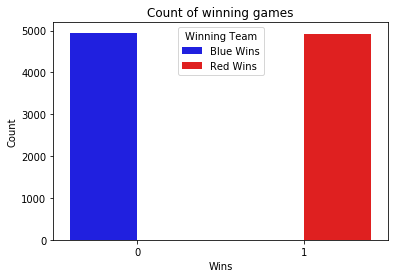

In [17]:
ax = sns.countplot(df['blueWins'], hue=df['blueWins'], palette=['blue', 'red'])
ax.set(xlabel='Wins', ylabel='Count')
ax.legend(title='Winning Team', loc='upper center', labels=['Blue Wins', 'Red Wins'])
ax.set_title('Count of winning games')
plt.show()

### Data Cleaning

*Dropping `gameId` since it is a unique value for each observation.*

In [18]:
df = df.drop(columns='gameId')

#### Checking correlation between features

In [19]:
columns = df.columns
for i in columns:
    for j in columns:
        if abs(df[i].corr(df[j])) >= 0.95:
            if i != j:
                print([i, j, df[i].corr(df[j])])
                columns = columns.drop(i)

['blueFirstBlood', 'redFirstBlood', -1.0]
['blueKills', 'redDeaths', 1.0]
['blueDeaths', 'redKills', 1.0]
['blueTotalGold', 'blueGoldPerMin', 1.0]
['blueTotalMinionsKilled', 'blueCSPerMin', 1.0]
['blueGoldDiff', 'redGoldDiff', -1.0]
['blueExperienceDiff', 'redExperienceDiff', -1.0]
['redTotalGold', 'redGoldPerMin', 1.0]
['redTotalMinionsKilled', 'redCSPerMin', 0.9999999999999996]


In [20]:
print((df['blueKills'] == df['redDeaths']).value_counts())
print((df['blueDeaths'] == df['redKills']).value_counts())
print((df['redTotalGold'] / 10 == df['redGoldPerMin']).value_counts())
print((df['blueTotalGold'] / 10 == df['blueGoldPerMin']).value_counts())
print((df['redTotalMinionsKilled'] / 10 == df['redCSPerMin']).value_counts())
print((df['blueTotalMinionsKilled'] / 10 == df['blueCSPerMin']).value_counts())
print((df['redEliteMonsters'] == (df['redDragons'] + df['redHeralds'])).value_counts())
print((df['blueEliteMonsters'] == (df['blueDragons'] + df['blueHeralds'])).value_counts())
print((df['blueGoldDiff'] == (df['blueTotalGold'] - df['redTotalGold'])).value_counts())
print((df['redGoldDiff'] == (df['redTotalGold'] - df['blueTotalGold'])).value_counts())
print((df['blueExperienceDiff'] == (df['blueTotalExperience'] - df['redTotalExperience'])).value_counts())
print((df['redExperienceDiff'] == (df['redTotalExperience'] - df['blueTotalExperience'])).value_counts())

True    9879
dtype: int64
True    9879
dtype: int64
True    9879
dtype: int64
True    9879
dtype: int64
True    9879
dtype: int64
True    9879
dtype: int64
True    9879
dtype: int64
True    9879
dtype: int64
True    9879
dtype: int64
True    9879
dtype: int64
True    9879
dtype: int64
True    9879
dtype: int64


*we can see above that variables with correlation of 1 or -1 are repeated, so we can minimize them later*

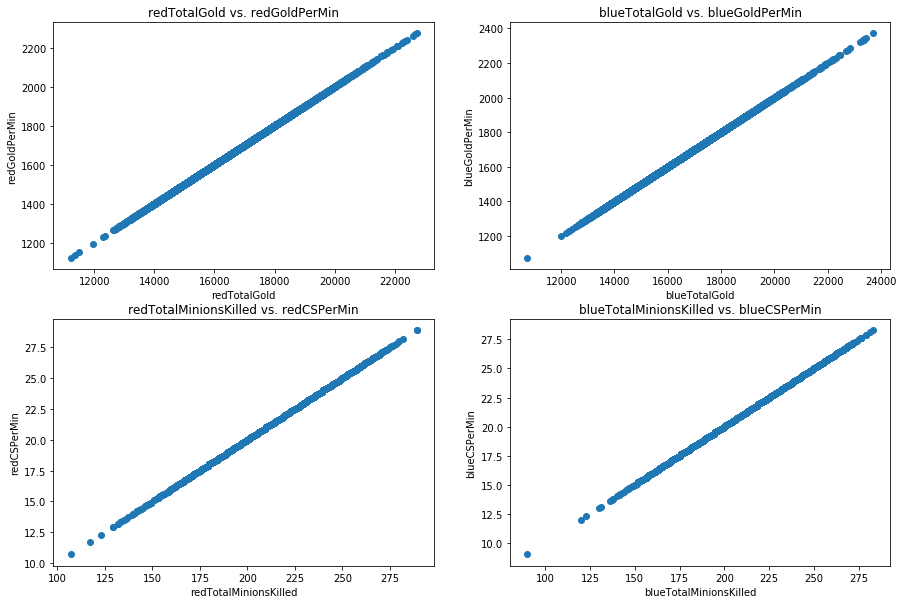

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0,0].scatter('redTotalGold','redGoldPerMin', data=df)
ax[0,0].set_title('redTotalGold vs. redGoldPerMin')
ax[0,0].set_ylabel('redGoldPerMin')
ax[0,0].set_xlabel('redTotalGold')

ax[0,1].scatter('blueTotalGold','blueGoldPerMin', data=df)
ax[0,1].set_title('blueTotalGold vs. blueGoldPerMin')
ax[0,1].set_ylabel('blueGoldPerMin')
ax[0,1].set_xlabel('blueTotalGold')

ax[1,0].scatter('redTotalMinionsKilled','redCSPerMin', data=df)
ax[1,0].set_title('redTotalMinionsKilled vs. redCSPerMin')
ax[1,0].set_ylabel('redCSPerMin')
ax[1,0].set_xlabel('redTotalMinionsKilled')

ax[1,1].scatter('blueTotalMinionsKilled','blueCSPerMin', data=df)
ax[1,1].set_title('blueTotalMinionsKilled vs. blueCSPerMin')
ax[1,1].set_ylabel('blueCSPerMin')
ax[1,1].set_xlabel('blueTotalMinionsKilled')

plt.show()

*Dealing with features with high correlation*
- `blueFirstBlood` and `redFirstBlood` are inversely correlated since only one team can score first blood in the game. Dropping one feature
- `blueKills` and `redDeaths`, and `blueDeaths` and `redKills` are perfectly correlated and have same data since the game is only between two teams.
- `redCSPerMin`, `redGoldPerMin`, `redExperienceDiff`, `redGoldDiff`, `blueGoldDiff`, `blueCSPerMin`, `blueExperienceDiff`, `redEliteMonsters`, `blueEliteMonsters` and `blueGoldPerMin`, are all derived values

In [22]:
df = df.drop(columns=['redFirstBlood', 'redDeaths', 'redKills', 'redGoldPerMin', 'blueGoldPerMin', 'redCSPerMin', 'blueCSPerMin', 'blueGoldDiff', 'redGoldDiff', 'blueExperienceDiff', 'redExperienceDiff', 'redEliteMonsters', 'blueEliteMonsters'])

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   blueWins                      9879 non-null   int64  
 1   blueWardsPlaced               9879 non-null   int64  
 2   blueWardsDestroyed            9879 non-null   int64  
 3   blueFirstBlood                9879 non-null   int64  
 4   blueKills                     9879 non-null   int64  
 5   blueDeaths                    9879 non-null   int64  
 6   blueAssists                   9879 non-null   int64  
 7   blueDragons                   9879 non-null   int64  
 8   blueHeralds                   9879 non-null   int64  
 9   blueTowersDestroyed           9879 non-null   int64  
 10  blueTotalGold                 9879 non-null   int64  
 11  blueAvgLevel                  9879 non-null   float64
 12  blueTotalExperience           9879 non-null   int64  
 13  blu

In [24]:
clean_corr = df.corr()
clean_corr['blueWins'].sort_values(ascending=False)

blueWins                        1.000000
blueTotalGold                   0.417213
blueTotalExperience             0.396141
blueAvgLevel                    0.357820
blueKills                       0.337358
blueAssists                     0.276685
blueTotalMinionsKilled          0.224909
blueDragons                     0.213768
blueFirstBlood                  0.201769
blueTotalJungleMinionsKilled    0.131445
blueTowersDestroyed             0.115566
blueHeralds                     0.092385
blueWardsDestroyed              0.044247
blueWardsPlaced                 0.000087
redWardsPlaced                 -0.023671
redWardsDestroyed              -0.055400
redHeralds                     -0.097172
redTowersDestroyed             -0.103696
redTotalJungleMinionsKilled    -0.110994
redDragons                     -0.209516
redTotalMinionsKilled          -0.212171
redAssists                     -0.271047
blueDeaths                     -0.339297
redAvgLevel                    -0.352127
redTotalExperien

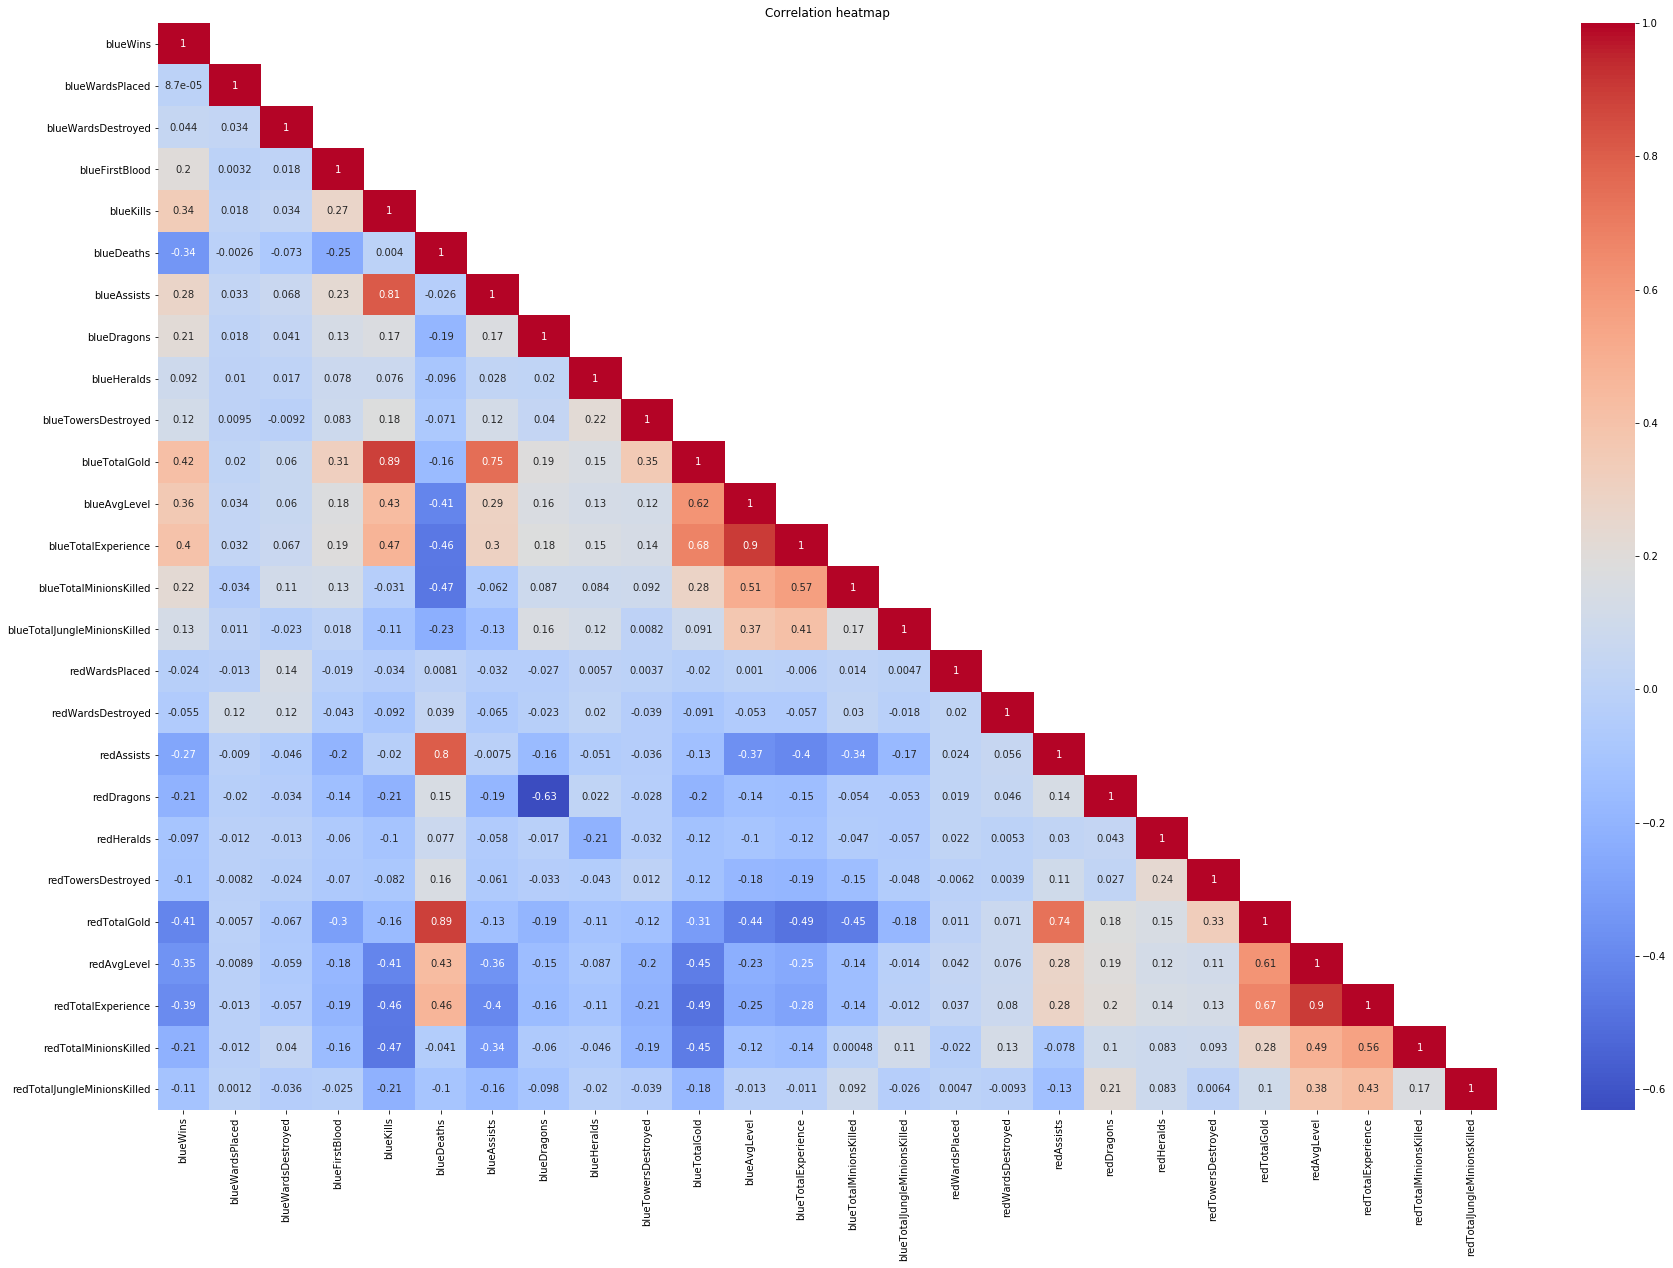

In [25]:
f, ax = plt.subplots(figsize= (30, 20))
lower = clean_corr.where(np.tril(np.ones(clean_corr.shape)).astype(np.bool))
hmap=sns.heatmap(lower,cmap="coolwarm", annot=True)
ax.set_title('Correlation heatmap')
plt.savefig('clean-corr-half.png')

*['blueTotalGold' , 'blueTotalExperience', blueAvgLevel, 'blueKills', 'blueAssists', 'blueTotalMinionsKilled', 'blueDragons', 'blueFirstBlood'], those feature have more higher corrlation than other features with blueWins*

### Identify Missing Data

In [26]:
df.describe()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,...,redWardsDestroyed,redAssists,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled
count,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,...,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,0.499038,22.288288,2.824881,0.504808,6.183925,6.137666,6.645106,0.361980,0.187974,0.051422,...,2.723150,6.662112,0.413098,0.160036,0.043021,16489.041401,6.925316,17961.730438,217.349226,51.313088
std,0.500024,18.019177,2.174998,0.500002,3.011028,2.933818,4.064520,0.480597,0.390712,0.244369,...,2.138356,4.060612,0.492415,0.366658,0.216900,1490.888406,0.305311,1198.583912,21.911668,10.027885
min,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,11212.000000,4.800000,10465.000000,107.000000,4.000000
25%,0.000000,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,...,1.000000,4.000000,0.000000,0.000000,0.000000,15427.500000,6.800000,17209.500000,203.000000,44.000000
50%,0.000000,16.000000,3.000000,1.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,...,2.000000,6.000000,0.000000,0.000000,0.000000,16378.000000,7.000000,17974.000000,218.000000,51.000000
75%,1.000000,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,0.000000,0.000000,...,4.000000,9.000000,1.000000,0.000000,0.000000,17418.500000,7.200000,18764.500000,233.000000,57.000000
max,1.000000,250.000000,27.000000,1.000000,22.000000,22.000000,29.000000,1.000000,1.000000,4.000000,...,24.000000,28.000000,1.000000,1.000000,2.000000,22732.000000,8.200000,22269.000000,289.000000,92.000000


In [27]:
df.isnull().sum().sum()

0

In [28]:
df.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,...,redWardsDestroyed,redAssists,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled
0,0,28,2,1,9,6,11,0,0,0,...,6,8,0,0,0,16567,6.8,17047,197,55
1,0,12,1,0,5,5,5,0,0,0,...,1,2,1,1,1,17620,6.8,17438,240,52
2,0,15,0,0,7,11,4,1,0,0,...,3,14,0,0,0,17285,6.8,17254,203,28
3,0,43,1,0,4,5,5,0,1,0,...,2,10,0,0,0,16478,7.0,17961,235,47
4,0,75,4,0,6,6,6,0,0,0,...,2,7,1,0,0,17404,7.0,18313,225,67


In [29]:
df.applymap(np.isreal).all().sum()

26

In [30]:
df.applymap(lambda x: isinstance(x, (int, float))).all().sum()

26

*For missing value, first see use df.describe() to see min/max in each columns. ensure each feature in right range. Then, we use df.isnull() to see pandas that can identify any missing value. Since our data contain all numeric features, we also use applymap function with np.isreal or isinstance, search for each row and each column to see if there any missing value can find. Base on the result, our data do not have any missing values.*

In [31]:
print('Lenght of columms {}'.format(len(df.columns)))

Lenght of columms 26


In [32]:
df.columns

Index(['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood',
       'blueKills', 'blueDeaths', 'blueAssists', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'redWardsPlaced', 'redWardsDestroyed',
       'redAssists', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalGold', 'redAvgLevel', 'redTotalExperience',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled'],
      dtype='object')

### Outliers

In [33]:
def plot_violinplot(df,ax_key):
    df = pd.melt(df, id_vars='blueWins', var_name='Features', value_name='Values')
    sns.violinplot(x='Features', y='Values', hue='blueWins', data=df, split=True,
               inner='quart', ax=ax[ax_key], palette='muted').set_title('showing outliers using voilin plot ')
    fig.autofmt_xdate(rotation=45)

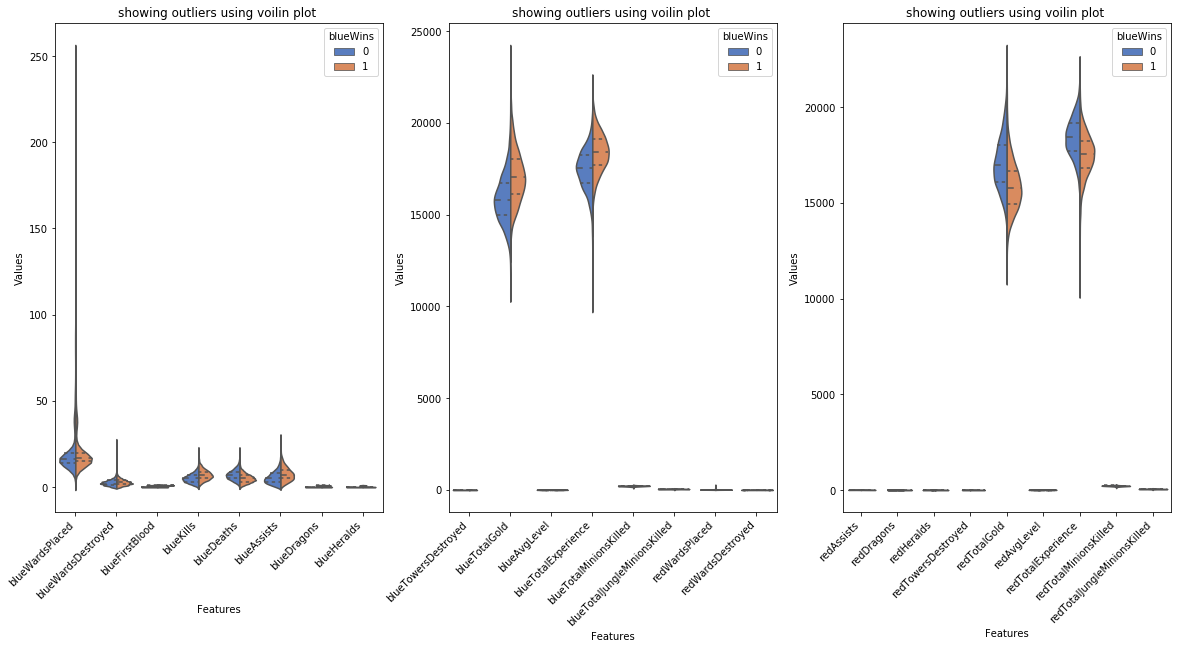

In [34]:
fig, ax = plt.subplots(1,3,figsize=(20,10))
data = df.loc[:, df.columns != 'blueWins']
data = pd.DataFrame(data = data, columns = data.columns)
data1 = pd.concat([df.blueWins, data.iloc[:, 0:8]], axis=1)
plot_violinplot(data1,0)
data2 = pd.concat([df.blueWins, data.iloc[:, 8:16]], axis=1)
plot_violinplot(data2,1)
data3 = pd.concat([df.blueWins, data.iloc[:, 16:]], axis=1)
plot_violinplot(data3,2)
plt.show()

*let's plot with standardized value to see better visualization*

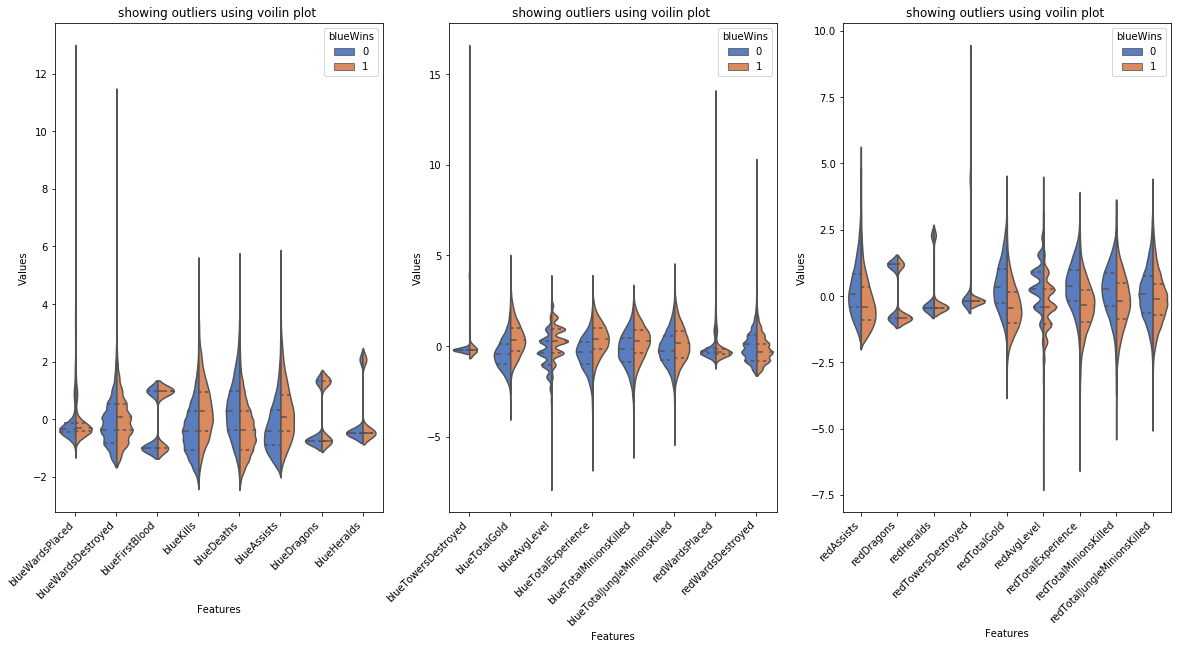

In [35]:
fig, ax = plt.subplots(1,3,figsize=(20,10))
data = df.loc[:, df.columns != 'blueWins']
data_std = StandardScaler().fit_transform(data)
data_std = pd.DataFrame(data = data_std, columns = data.columns)
data1 = pd.concat([df.blueWins, data_std.iloc[:, 0:8]], axis=1)
plot_violinplot(data1,0)
data2 = pd.concat([df.blueWins, data_std.iloc[:, 8:16]], axis=1)
plot_violinplot(data2,1)
data3 = pd.concat([df.blueWins, data_std.iloc[:, 16:]], axis=1)
plot_violinplot(data3,2)
plt.show()

*Our data contain outliers. But since those are about game performance for each group, like red group performed well in one game, but performance bad in other games. we decide to keep those outliers since there is no unit. and these outliers could better give feedback on which team will win the game.*

### Split data

In [36]:
y = df['blueWins']
X = df.loc[:, df.columns != 'blueWins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)

test_df = pd.concat([X_test, y_test], axis=1)
train_df = pd.concat([X_train, y_train], axis=1)

train_df.to_csv('../datasets/train.csv', index=False)
test_df.to_csv('../datasets/test.csv', index = False)

print('Labels count in y: ', np.bincount(y))
print('Labels count in y_train ', np.bincount(y_train))
print('Labels count in y_test', np.bincount(y_test))

Labels count in y:  [4949 4930]
Labels count in y_train  [3464 3451]
Labels count in y_test [1485 1479]


*The data has been split into training and testing set. The training data contain 6915 observations and the test data contain 2964 observations. we also use stratify=y to eunsures that both training and test datasets have the same class proportions as the original dataset.*

## Methods

In [37]:
df = pd.read_csv('../datasets/train.csv')
mainTest = pd.read_csv('../datasets/test.csv')

In [38]:
df.columns

Index(['blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood', 'blueKills',
       'blueDeaths', 'blueAssists', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'redWardsPlaced', 'redWardsDestroyed',
       'redAssists', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalGold', 'redAvgLevel', 'redTotalExperience',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'blueWins'],
      dtype='object')

### PreScaling Data

In [39]:
X = df.loc[:, ~df.columns.isin(['blueWins'])]
y = df['blueWins']

X1 = mainTest.loc[:, ~mainTest.columns.isin(['blueWins'])]
y1 = mainTest['blueWins']

sc = StandardScaler()
mm = MinMaxScaler()

X_std = sc.fit_transform(X)
X_mm = mm.fit_transform(X)

X1_std = sc.fit_transform(X1)
X1_mm = mm.fit_transform(X1)

df_std = pd.DataFrame(X_std, columns=X.columns)
df_mm = pd.DataFrame(X_mm, columns=X.columns)

mainTest_std = pd.DataFrame(X1_std, columns=X1.columns)
mainTest_mm = pd.DataFrame(X1_mm, columns=X1.columns)

We do feature scaling via normalization and standardization.we want to compare the modle if we do feature and if we dont do it. so we create three data frame for easy compare.
only decision trees and random forests are two algorithms that don't need to worry about it.

In [40]:
steps = {
    'LogisticRegression': [('LogisticRegression', LogisticRegression())],
    'K-Nearest Neighbors': [('K-Nearest Neighbors', KNeighborsClassifier())],
    'DecisionTree': [('DecisionTree', DecisionTreeClassifier())],
    'RandomForest': [('RandomForest', RandomForestClassifier())],
    'SVM': [('SVM', SVC())],
}

### Standard Scaled Data

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df_std, y, test_size=0.3, stratify=y, random_state=SEED)

sspipe = {}
for key in steps.keys():
    sspipe[key] = Pipeline(steps[key])
    sspipe[key].fit(X_train, y_train)
    print('[{}] Classification accuracy without selecting features: {:.3f}'
          .format(key, sspipe[key].score(X_test, y_test)))



[LogisticRegression] Classification accuracy without selecting features: 0.734
[K-Nearest Neighbors] Classification accuracy without selecting features: 0.682
[DecisionTree] Classification accuracy without selecting features: 0.634
[RandomForest] Classification accuracy without selecting features: 0.713
[SVM] Classification accuracy without selecting features: 0.724


### MinMax

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df_mm, y, test_size=0.3, stratify=y, random_state=SEED)

mmpipe = {}
for key in steps.keys():
    mmpipe[key] = Pipeline(steps[key])
    mmpipe[key].fit(X_train, y_train)
    print('[{}] Classification accuracy without selecting features: {:.3f}'
      .format(key, mmpipe[key].score(X_test, y_test)))

[LogisticRegression] Classification accuracy without selecting features: 0.728
[K-Nearest Neighbors] Classification accuracy without selecting features: 0.681
[DecisionTree] Classification accuracy without selecting features: 0.622
[RandomForest] Classification accuracy without selecting features: 0.715
[SVM] Classification accuracy without selecting features: 0.724


### Unscaled Data

In [43]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns!='blueWins'], df['blueWins'], test_size=0.3, stratify=df['blueWins'], random_state=SEED)

pipe = {}
for key in steps.keys():
    pipe[key] = Pipeline(steps[key])
    pipe[key].fit(X_train, y_train)
    print('[{}] Classification accuracy without selecting features: {:.3f}'
      .format(key, pipe[key].score(X_test, y_test)))
    

[LogisticRegression] Classification accuracy without selecting features: 0.728
[K-Nearest Neighbors] Classification accuracy without selecting features: 0.670
[DecisionTree] Classification accuracy without selecting features: 0.629
[RandomForest] Classification accuracy without selecting features: 0.715
[SVM] Classification accuracy without selecting features: 0.726


__Logistic Regression seems to pull ahead with scaled or unscaled data__

*Accuracy Score Table*

|                 | Logistic|   SVM   | RandomForest | KNN     | DecisionTree |
| :-------------: | :-----: |:-------:| :----------: | :-----: | :----------: |
| UnScaled        | 72.8%   |  72.6%  |    71.6%     | 67.0%   | 63.4%        |
| Standard Scaler | 73.4%   |  72.4%  |    71.2%     | 68.2%   | 62.9%        |
| MinMax Scale    | 72.8%   |  72.4%  |    71.7%     | 68.1%   | 63.1%        |



the models we uses are Logistic Regression, K-Nearest Neighbors, Decision Tree, Random Forest and SVM. Decision Trees and Random Forests after scaling feature will decrease accuracy in our model. Logistic and SVM are perform well. After scaling feature, log, Random Forest and KNN improve their performance. We also use Tensorflow Keras to build classfication model.

## Evaluation

### Feature Importance with random Forests

In [44]:
def featureImp(importance, title):
    cols = X_train.columns
    collen = len(cols)
    indices = np.argsort(importance)[::-1]
    y_ticks = np.arange(0, collen)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(y_ticks, importance[indices])
    ax.set_yticklabels(cols[indices])
    ax.set_yticks(y_ticks)
    ax.set_title(title)
    fig.tight_layout()
    plt.show()

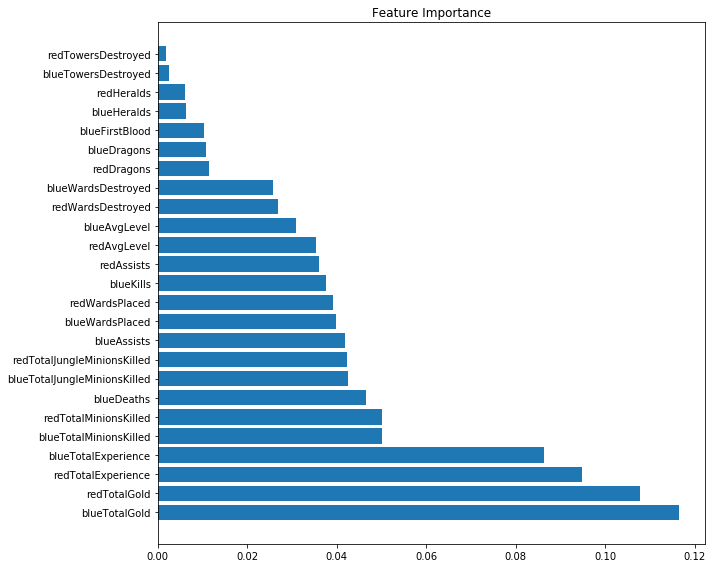

In [46]:
feature_importances = sspipe['RandomForest']['RandomForest'].feature_importances_

featureImp(sspipe['RandomForest']['RandomForest'].feature_importances_, 'Feature Importance')

*We can see that total gold of each team is most important*

### PCA

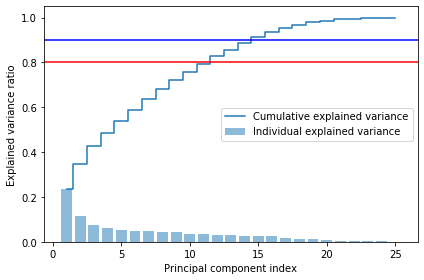

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df_std, y, test_size=0.3, stratify=y, random_state=SEED)

cov_mat = np.cov(X_train.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
plt.bar(range(1,26), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1,26), cum_var_exp, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.axhline(y=0.8, color='r', linestyle='-')
plt.axhline(y=0.9, color='b', linestyle='-')
plt.tight_layout()
plt.show()

To explain 80% variance of the data more than 10 components are required. And to explain 90% it requires 14 components.

In [40]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

In [41]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.02):
    
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # plot examples by class
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.3,
                    color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx],
                    label=cl, s= 10)

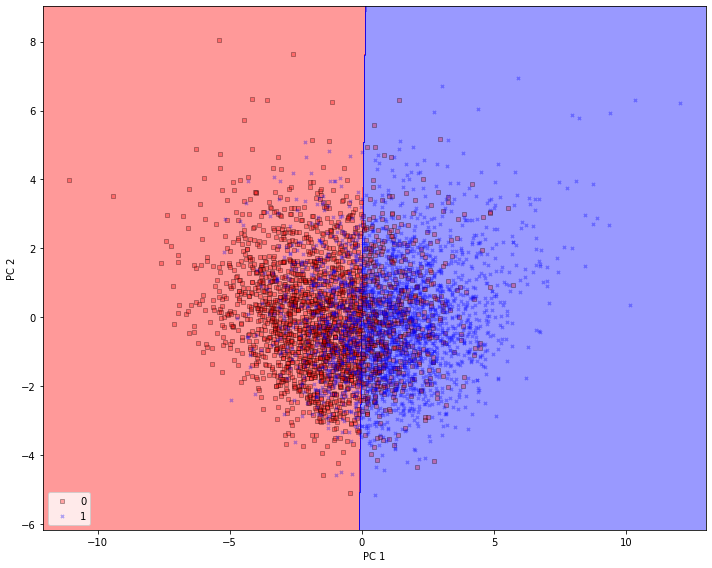

In [42]:
# initializing the PCA transformer and
# logistic regression estimator:
pca = PCA(n_components=2)
lr = LogisticRegression(random_state=42)

# dimensionality reduction:
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
# fitting the logistic regression model on the reduced dataset:
lr.fit(X_train_pca, y_train)

plt.figure(figsize=(10,8))
plot_decision_regions(X_train_pca, y_train, classifier=lr)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

PCA are not perfectly linearly separable

### Classification LDA

In [43]:
np.set_printoptions(precision=4)
X_train_std = X_train.to_numpy()
mean_vecs = []
for label in range(0,2):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print('MV %s: %s\n' %(label, mean_vecs[label-1]))

MV 0: [-0.0112 -0.0421 -0.203  -0.3219  0.3478 -0.2683 -0.2061 -0.0646 -0.1089
 -0.3997 -0.3548 -0.3843 -0.2201 -0.1314  0.0347  0.0599  0.2647  0.2135
  0.0962  0.1155  0.4155  0.3556  0.3918  0.2092  0.0908]

MV 1: [-0.0112 -0.0421 -0.203  -0.3219  0.3478 -0.2683 -0.2061 -0.0646 -0.1089
 -0.3997 -0.3548 -0.3843 -0.2201 -0.1314  0.0347  0.0599  0.2647  0.2135
  0.0962  0.1155  0.4155  0.3556  0.3918  0.2092  0.0908]



In [44]:
d = 25 # number of features

S_W = np.zeros((d, d))
for label, mv in zip(range(0, 2), mean_vecs):
    class_scatter = np.zeros((d, d))

for row in X_train_std[y_train == label]:
    row, mv = row.reshape(d, 1), mv.reshape(d, 1)
    class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter

print('Within-class scatter matrix: %sx%s' % ( S_W.shape[0], S_W.shape[1]))
print('Class label distribution: %s'  % np.bincount(y_train))

Within-class scatter matrix: 25x25
Class label distribution: [2425 2415]


In [45]:
d = 25 # number of features

S_W = np.zeros((d, d))

for label,mv in zip(range(0, 2), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter

print('Scaled within-class scatter matrix: %sx%s'
        % (S_W.shape[0], S_W.shape[1]))

Scaled within-class scatter matrix: 25x25


In [46]:
mean_overall = np.mean(X_train_std, axis=0)

d = 25 # number of features

S_B = np.zeros((d, d))

for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1) # make column vector
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot(
    (mean_vec - mean_overall).T)
print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 25x25


In [47]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [48]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]

eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

print('Eigenvalues in descending order:\n')

for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

468.7412279110426
1.4443568649104038e-12
1.0054875684660018e-12
3.834080766580628e-13
3.627735651480299e-13
3.627735651480299e-13
2.406491922710086e-13
2.406491922710086e-13
1.9855411511531525e-13
1.9855411511531525e-13
1.5023777852593478e-13
1.180485096582073e-13
9.388000300057392e-14
9.388000300057392e-14
8.137739926372757e-14
4.428259954742729e-14
3.8992792116198885e-14
2.868250789551062e-14
2.50769583658008e-14
2.50769583658008e-14
2.07277256180823e-14
4.224398115145755e-15
4.224398115145755e-15
2.069154645087169e-15
3.974536279957439e-16


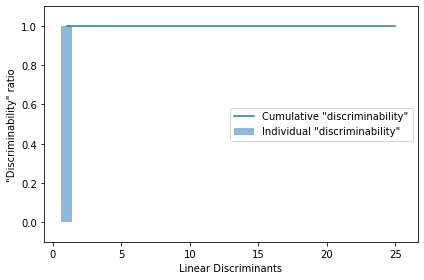

In [49]:
tot = sum(eigen_vals.real)

discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]

cum_discr = np.cumsum(discr)
plt.bar(range(1, 26), discr, alpha=0.5, align='center', label='Individual "discriminability"')

plt.step(range(1, 26), cum_discr, where='mid', label='Cumulative "discriminability"')

plt.ylabel('"Discriminability" ratio')

plt.xlabel('Linear Discriminants')

plt.ylim([-0.1, 1.1])

plt.legend(loc='best')

plt.tight_layout()

plt.show()


As we can see in the resulting figure, the first linear discriminants alone capture 100 percent of the useful information in the training dataset

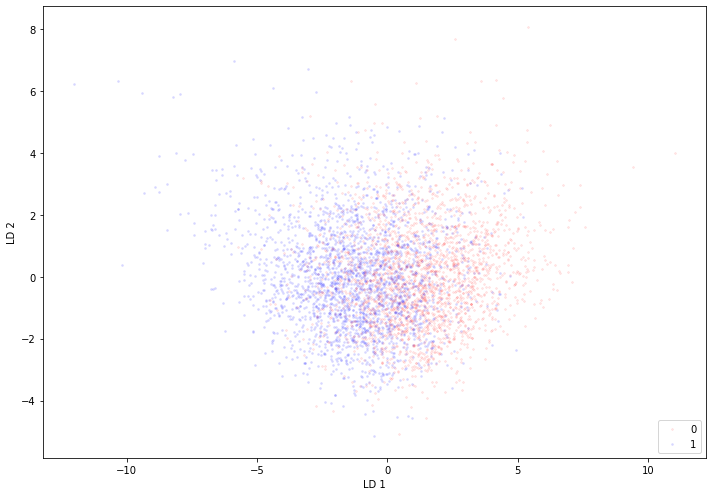

In [50]:
X_train_lda = X_train_std.dot(w)

colors = ['r', 'b']
markers = ['x', 'o']

plt.figure(figsize=(10,7))

for l, c, m in zip(np.unique(y_train), colors, markers):
     plt.scatter(X_train_lda[y_train==l, 0], X_train_lda[y_train==l, 1] * (-1),
    c=c, label=l, marker=m, s=3, alpha=0.1)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Doing LDA the outcome are not perfectly linearly separable

### GridSearchCV

In [51]:
lr = LogisticRegression(random_state=42, C = 1)

param_grid = {'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

lr_cv = GridSearchCV(lr, param_grid, cv=10)
lr_cv.fit(X_train, y_train)

print(lr_cv.best_params_) 
print(lr_cv.best_score_)

{'C': 0.001}
0.7328512396694216


In [52]:
param_grid = {'n_neighbors': np.arange(1,25)} 

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=10) 

knn_cv.fit(X_train,y_train) 
print(knn_cv.best_params_) 
print(knn_cv.best_score_)

{'n_neighbors': 21}
0.7068181818181818


In [53]:
pipe_svc = make_pipeline(SVC(random_state=42))

param_range = [ 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy',cv=10,refit=True,n_jobs=-1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.7320247933884296
{'svc__C': 0.01, 'svc__kernel': 'rbf'}


### ROC & AUC

In [54]:
from MajorityVoteClassifier import MajorityVoteClassifier

In [55]:
clf1 = LogisticRegression(random_state=42, C = 0.001)
clf2 = DecisionTreeClassifier(random_state=42)
clf3 = KNeighborsClassifier(n_neighbors=21)
clf4 = RandomForestClassifier(random_state=42)
clf5 = SVC(random_state=42, probability = True, C=0.01, kernel='rbf')

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
pipe5 = Pipeline([['sc', StandardScaler()], ['clf', clf5]])
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3, clf4, pipe5])
    
clf_labels = ['Logistic regression', 'Decision tree', 'KNN', 'RandomForestClassifier', 'SVM', 'mv_clf']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3, clf4, pipe5, mv_clf], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.81 (+/- 0.02) [Logistic regression]
ROC AUC: 0.63 (+/- 0.01) [Decision tree]
ROC AUC: 0.78 (+/- 0.02) [KNN]
ROC AUC: 0.79 (+/- 0.02) [RandomForestClassifier]
ROC AUC: 0.79 (+/- 0.02) [SVM]
ROC AUC: 0.78 (+/- 0.01) [mv_clf]


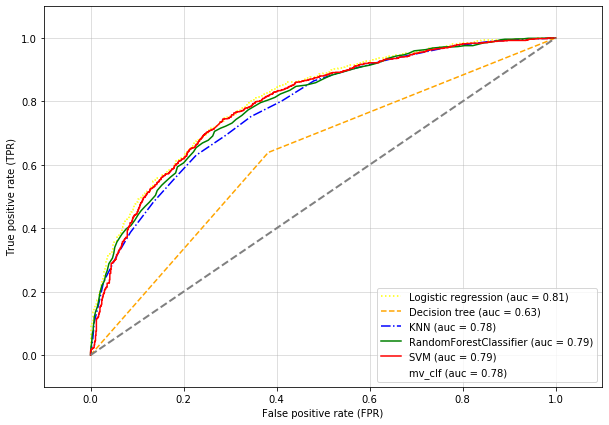

In [56]:
colors = ['yellow', 'orange', 'b', 'green', 'r', 'black']
all_clf = [pipe1, clf2, pipe3, clf4, pipe5, mv_clf]
linestyles = [':', '--', '-.', '-', 'solid', '']


plt.figure(figsize=(10,7))

for clf, label, clr, ls \
    in zip(all_clf, clf_labels, colors, linestyles):
    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc_roc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

Logistics regression has aucroc=.81, which means Logistic regression has a excellent performance

### Debugging algorithms with learning and validation curves

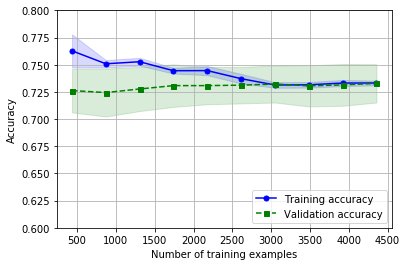

In [57]:
pipe_lr = make_pipeline(LogisticRegression(random_state= 42, C=0.001))


train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,X=X_train,
                                    y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,train_mean + train_std, train_mean - train_std,alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,color='green', linestyle='--', marker='s', markersize=5,label='Validation accuracy')

plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()

plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.6, 0.8])
plt.show()

*In Logistic Regression, the training accuracy and validation accuracy get closer as the number of training examples increases*

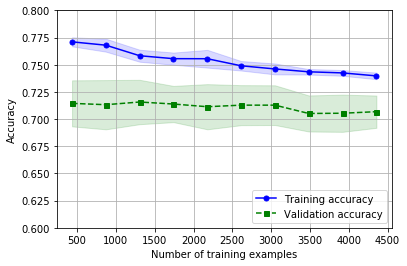

In [58]:
pipe_knn = make_pipeline(KNeighborsClassifier(n_neighbors=21))


train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_knn,X=X_train,
                                    y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,train_mean + train_std, train_mean - train_std,alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,color='green', linestyle='--', marker='s', markersize=5,label='Validation accuracy')

plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()

plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.6, 0.8])
plt.show()

*In KNN, training accuracy and validation accuracy get closer outside of our training examples*

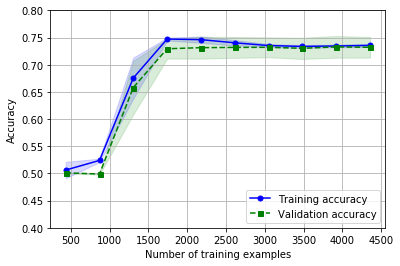

In [59]:
svm_lr = make_pipeline(SVC(random_state= 42, C=0.01))


train_sizes, train_scores, test_scores = learning_curve(estimator=svm_lr, X=X_train,
                                    y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,train_mean + train_std, train_mean - train_std,alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,color='green', linestyle='--', marker='s', markersize=5,label='Validation accuracy')

plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()

plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.4, 0.8])
plt.show()

*In SVC, both training accuracy and validation accuracy increase substantially until about 1750 training example mark. Then, they proceed in a constant rate.*

### Using real Test Set

Logistic regression 0.727
Decision tree 0.631
KNN 0.701
RandomForestClassifier 0.717
SVM 0.725


(0.0, 1.0, 0.0, 1.0)

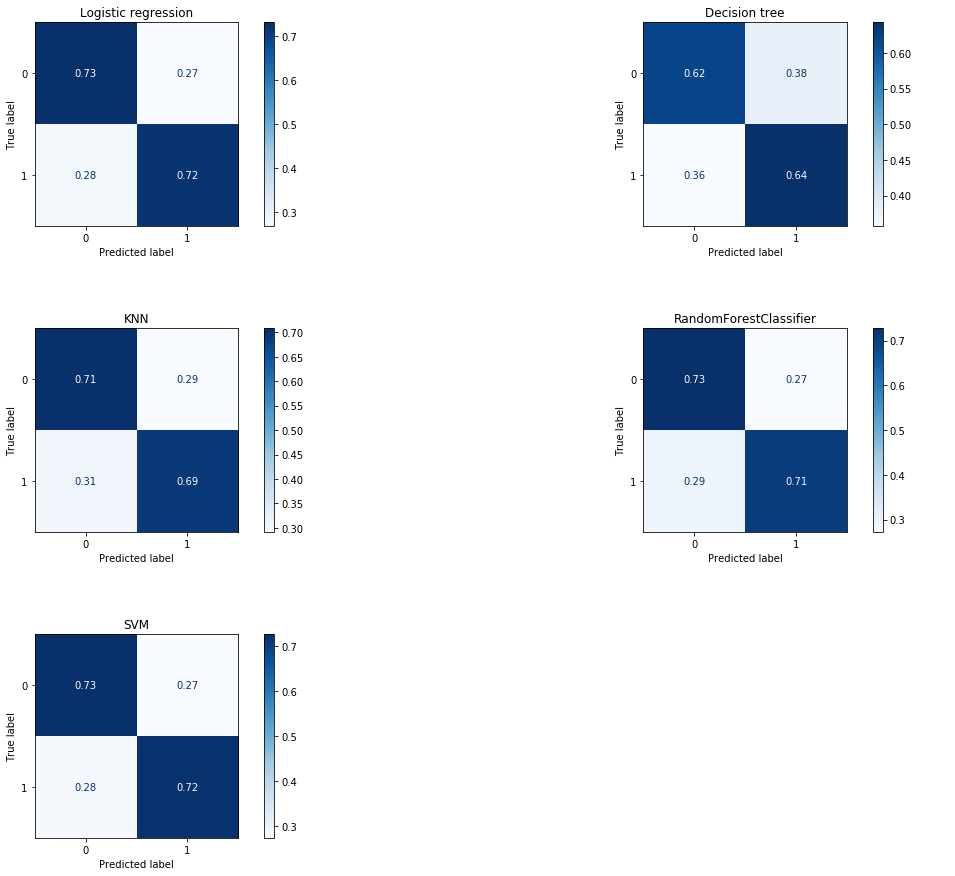

In [106]:
X = df.loc[:, ~df.columns.isin(['blueWins'])]
y = df['blueWins']

X1 = mainTest.loc[:, ~mainTest.columns.isin(['blueWins'])]
y1 = mainTest['blueWins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)

clf1 = LogisticRegression(random_state=42, C = 0.001)
clf2 = DecisionTreeClassifier(random_state=42)
clf3 = KNeighborsClassifier(n_neighbors=21)
clf4 = RandomForestClassifier(random_state=42)
clf5 = SVC(random_state=42, probability = True, C=1.0, kernel='rbf')

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
pipe5 = Pipeline([['sc', StandardScaler()], ['clf', clf5]])
    
clf_labels = ['Logistic regression', 'Decision tree', 'KNN', 'RandomForestClassifier', 'SVM']
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20, 15))
for clf, label, ax in zip([pipe1, clf2, pipe3, clf4, pipe5], clf_labels, (ax1, ax2, ax3, ax4, ax5)):
    clf.fit(X_train, y_train)
    print(label, round(clf.score(X_test, y_test),3))
    plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, normalize = 'true', ax=ax)
    ax.set_title(label)
plt.subplots_adjust(hspace=0.5)
ax6.axis('off')

Logistic regression 0.723
Decision tree 0.64
KNN 0.706
RandomForestClassifier 0.721
SVM 0.721


(0.0, 1.0, 0.0, 1.0)

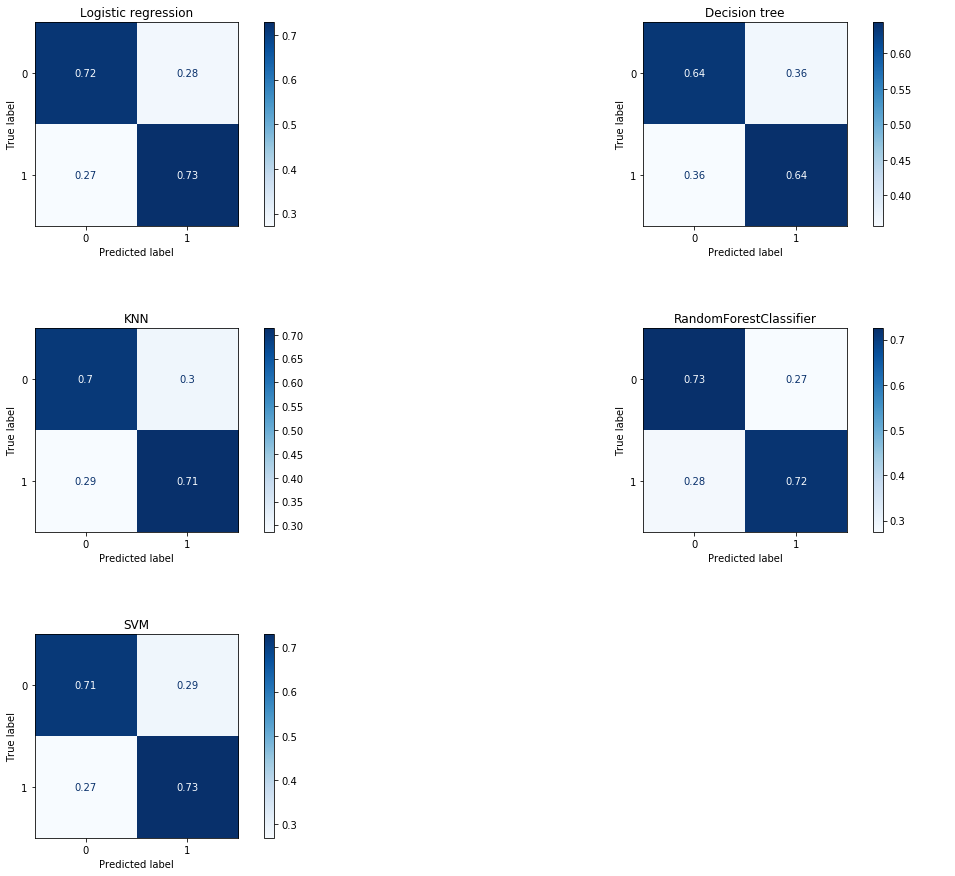

In [107]:
X = df.loc[:, ~df.columns.isin(['blueWins'])]
y = df['blueWins']

X1 = mainTest.loc[:, ~mainTest.columns.isin(['blueWins'])]
y1 = mainTest['blueWins']


clf1 = LogisticRegression(random_state=42, C = 0.001)
clf2 = DecisionTreeClassifier(random_state=42)
clf3 = KNeighborsClassifier(n_neighbors=21)
clf4 = RandomForestClassifier(random_state=42)
clf5 = SVC(random_state=42, probability = True, C=1.0, kernel='rbf')

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
pipe5 = Pipeline([['sc', StandardScaler()], ['clf', clf5]])
    
clf_labels = ['Logistic regression', 'Decision tree', 'KNN', 'RandomForestClassifier', 'SVM']

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20, 15))
for clf, label, ax in zip([pipe1, clf2, pipe3, clf4, pipe5], clf_labels, (ax1, ax2, ax3, ax4, ax5)):
    clf.fit(X, y)
    print(label, round(clf.score(X1, y1),3))
    plot_confusion_matrix(clf, X1, y1, cmap=plt.cm.Blues, normalize = 'true', ax=ax)
    ax.set_title(label)
plt.subplots_adjust(hspace=0.5)
ax6.axis('off')


*Accuracy Score Table*

|                 | Logistic|   SVM   | RandomForest | KNN     | DecisionTree |
| :-------------: | :-----: |:-------:| :----------: | :-----: | :----------: |
| train data      | 72.7%   |  72.5%  |    71.7%     | 70.1%   | 63.1%        |
| test  data      | 72.3%   |  72.1%  |    72.1%     | 70.6%   | 64.0%        |


the performance of model such as svm, KNN increase accuacy compare to our first fit.
knn improve by finding the best k, the overall still logitsic regression perforam well, 
0.02 higher than svm.

### Classification Using Tensorflow Keras

#### UnScaled Data

In [62]:
y = keras.utils.to_categorical(y, 2)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'blueWins'], y, test_size=0.33, stratify=y, random_state=SEED)

#### Using 1 Dense Layer softmax

In [93]:
model = keras.Sequential()
model.add(keras.layers.Dense(2, activation='softmax', input_dim=len(X_test.columns)))
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 2)                 52        
Total params: 52
Trainable params: 52
Non-trainable params: 0
_________________________________________________________________


In [94]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [95]:
fits = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=0)

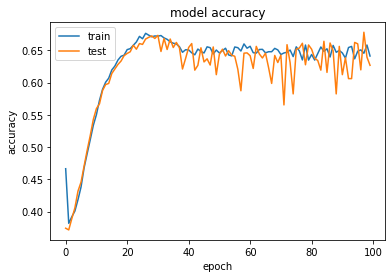

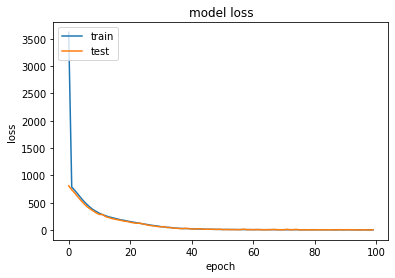

93/93 [==============================] - 0s 2ms/step - loss: 6.1590 - accuracy: 0.6447


[6.158984184265137, 0.6447368264198303]

In [96]:
plt.plot(fits.history['accuracy'])
plt.plot(fits.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(fits.history['loss'])
plt.plot(fits.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

y_true = keras.utils.to_categorical(y1, 2)
model.evaluate(mainTest.loc[:, mainTest.columns!='blueWins'], y_true)

#### Standard Scale

In [74]:
X_train, X_test, y_train, y_test = train_test_split(df_std, y, test_size=0.33, stratify=y, random_state=SEED)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 2)                 52        
Total params: 52
Trainable params: 52
Non-trainable params: 0
_________________________________________________________________


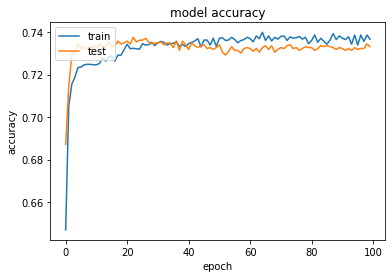

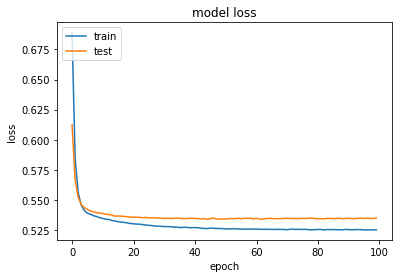

93/93 [==============================] - 0s 2ms/step - loss: 0.5304 - accuracy: 0.7190


[0.5304129719734192, 0.7189608812332153]

In [88]:
model = keras.Sequential()
model.add(keras.layers.Dense(2, activation='softmax', input_dim=len(X_test.columns)))
# model.add(keras.layers.Dense(2, activation='sigmoid'))
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
fits = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=0)
plt.plot(fits.history['accuracy'])
plt.plot(fits.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(fits.history['loss'])
plt.plot(fits.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evaluate
y_true = keras.utils.to_categorical(y1, 2)
model.evaluate(mainTest_std, y_true)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 4)                 104       
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 10        
Total params: 134
Trainable params: 134
Non-trainable params: 0
_________________________________________________________________


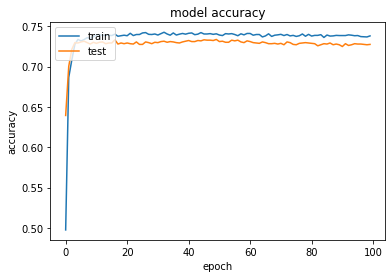

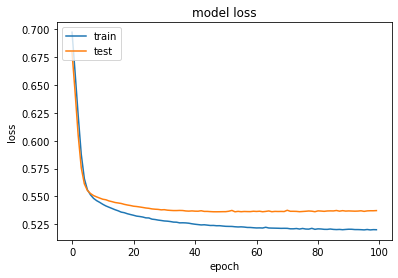

93/93 [==============================] - 0s 2ms/step - loss: 0.5354 - accuracy: 0.7196


[0.5353764891624451, 0.7196356058120728]

In [86]:
model = keras.Sequential()
model.add(keras.layers.Dense(4, activation='softmax', input_dim=len(X_test.columns)))
model.add(keras.layers.Dense(4, activation='relu'))
model.add(keras.layers.Dense(2, activation='sigmoid'))
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
fits = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=0)
plt.plot(fits.history['accuracy'])
plt.plot(fits.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(fits.history['loss'])
plt.plot(fits.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evaluate
y_true = keras.utils.to_categorical(y1, 2)
model.evaluate(mainTest_std, y_true)

### Min Max

In [89]:
X_train, X_test, y_train, y_test = train_test_split(df_mm, y, test_size=0.33, stratify=y, random_state=SEED)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 2)                 52        
Total params: 52
Trainable params: 52
Non-trainable params: 0
_________________________________________________________________


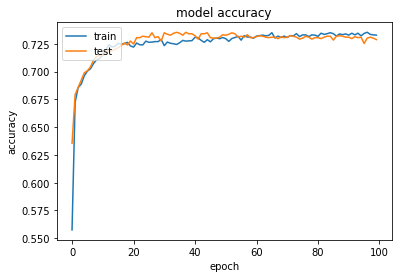

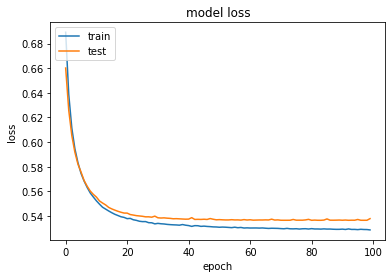

93/93 [==============================] - 0s 2ms/step - loss: 0.5977 - accuracy: 0.6839


[0.5977274179458618, 0.6838731169700623]

In [90]:
model = keras.Sequential()
model.add(keras.layers.Dense(2, activation='softmax', input_dim=len(X_test.columns)))
# model.add(keras.layers.Dense(2, activation='sigmoid'))
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
fits = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=0)
plt.plot(fits.history['accuracy'])
plt.plot(fits.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(fits.history['loss'])
plt.plot(fits.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evaluate
y_true = keras.utils.to_categorical(y1, 2)
model.evaluate(mainTest_mm, y_true)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 4)                 104       
_________________________________________________________________
dense_32 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_33 (Dense)             (None, 2)                 10        
Total params: 134
Trainable params: 134
Non-trainable params: 0
_________________________________________________________________


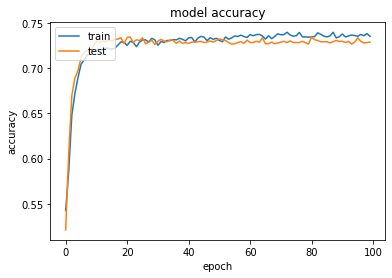

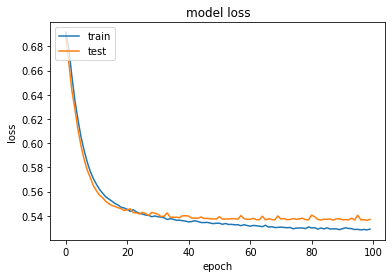

93/93 [==============================] - 0s 2ms/step - loss: 0.5747 - accuracy: 0.6967


[0.5746983289718628, 0.6966936588287354]

In [91]:
model = keras.Sequential()
model.add(keras.layers.Dense(4, activation='softmax', input_dim=len(X_test.columns)))
model.add(keras.layers.Dense(4, activation='relu'))
model.add(keras.layers.Dense(2, activation='sigmoid'))
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
fits = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=0)
plt.plot(fits.history['accuracy'])
plt.plot(fits.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(fits.history['loss'])
plt.plot(fits.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evaluate
y_true = keras.utils.to_categorical(y1, 2)
model.evaluate(mainTest_mm, y_true)

## Conclusion

*The accuracy of models ranges from 68-74%. Logisitic Regression does better in classifying. Keras/Tensorflow with single layer using `softmax` activation worked better on raw, standard scaled and min max scaled data. So, using the models we can be ~70% sure whether a blue team or red team is going to win based on first 10mins of game play stats.*

## Attribution

## Bibiliiography

Jagtap, Shayaan.(2018) How We Trained a Machine To Predict the Winning Team in League Of Legends. Retrieved from https://medium.com/trendkite-dev/machine-learning-league-of-legends-victory-predictions-8bc6cbc7754e
